In [2]:
import numpy as np
import pandas as pd
import vectorbt as vbt
import quantstats as qs
import matplotlib.pyplot as plt

from binance import Client
from binance.enums import HistoricalKlinesType

### 抓資料並切割樣本

In [3]:
#get binance data

client = Client()
value = client.get_historical_klines(symbol = 'BTCUSDT', 
                                      interval = '15m', 
                                      start_str = '2020-01-01', 
                                      end_str = '2023-08-15',
                                      klines_type=HistoricalKlinesType.FUTURES)

columns_name = ['openTime', 'Open', 'High', 'Low', 'Close', 'Volume', 'closeTime', 
                'quoteVolume', 'numTrade', 'takerBuyVolume', 'takerBuyQuoteVolume', 'ignore']

df = pd.DataFrame(value)
df.columns = columns_name
df['openTime']= pd.to_datetime(df['openTime'], unit='ms')
df = df.drop(['ignore', 'closeTime'], axis=1)
df = df.sort_values('openTime', ascending=True)
df = df.set_index('openTime')
df = df.astype(float)
df = df[~df.index.duplicated(keep='first')]

In [4]:
#split to in and out sample
price_all = df[['Open', 'High', 'Low', 'Close']]
price_is = price_all['2020-01-01':'2022-08-31'] # in sample data
price_os = price_all['2022-09-01':'2023-08-15'] # out sample data
print(price_all)
print(price_is)
print(price_os)

                         Open      High       Low     Close
openTime                                                   
2020-01-01 00:00:00   7189.43   7190.52   7172.94   7176.26
2020-01-01 00:15:00   7176.22   7179.41   7170.69   7172.36
2020-01-01 00:30:00   7172.79   7179.45   7170.61   7174.83
2020-01-01 00:45:00   7174.51   7179.36   7170.15   7171.55
2020-01-01 01:00:00   7171.43   7188.77   7171.10   7186.60
...                       ...       ...       ...       ...
2023-08-14 23:00:00  29426.50  29426.60  29413.40  29416.00
2023-08-14 23:15:00  29416.00  29419.50  29413.90  29418.80
2023-08-14 23:30:00  29418.80  29432.40  29414.30  29428.00
2023-08-14 23:45:00  29428.00  29430.50  29416.90  29419.50
2023-08-15 00:00:00  29419.50  29433.00  29406.50  29429.20

[126913 rows x 4 columns]
                         Open      High       Low     Close
openTime                                                   
2020-01-01 00:00:00   7189.43   7190.52   7172.94   7176.26
2020-01-01 00

### 定義策略

In [5]:
#double rsi as signal and filter
def rsi_long(close, rsi_window = 29, filter_window = 50):

    rsi_crossover = vbt.RSI.run(close, window=rsi_window).rsi_crossed_above(70).to_numpy()
    rsi_crossunder = vbt.RSI.run(close, window=rsi_window).rsi_crossed_below(30).to_numpy()

    rsi_filter = vbt.RSI.run(close, window = filter_window).rsi.to_numpy()

    signal = np.where(rsi_crossover & (rsi_filter > 70), 1, 0)
    signal = np.where(rsi_crossunder, -1, signal)

    return signal

MyInd = vbt.IndicatorFactory(
    class_name = 'rsi_long',
    short_name = 'long',
    input_names = ['close'],
    param_names = ['rsi_window', 'filter_window'],
    output_names = ['signals'] 
).from_apply_func(rsi_long, keep_pd=True)

### 參數優化

In [6]:
#run strategy and do parameter optimization on in sample data

win = np.arange(20, 50)
signal = MyInd.run(price_is['Close'] , rsi_window=win, filter_window=win, param_product = True)

entries = signal.signals == 1
exits = signal.signals == -1

portfolio = vbt.Portfolio.from_signals(
    price_is['Close'],
    #price_is['Close'].shift(-1), 
    entries, 
    exits,
    freq = '15m', 
    direction = 'longonly', 
    sl_stop = 0.03,
    fees = 0.0015
)

print(portfolio.total_return().sort_values())
print(portfolio.sharpe_ratio().sort_values())

long_rsi_window  long_filter_window
20               20                   -0.592385
21               21                   -0.528170
22               41                   -0.449519
                 42                   -0.423551
                 43                   -0.394123
                                         ...   
49               21                    4.982664
32               34                    5.034642
49               33                    5.117464
                 20                    5.157155
                 38                    5.674729
Name: total_return, Length: 900, dtype: float64
long_rsi_window  long_filter_window
22               41                   -0.805691
                 42                   -0.721886
                 43                   -0.712548
21               48                   -0.612060
                 44                   -0.562227
                                         ...   
32               34                    1.777865
33              

In [7]:
pf = pd.concat([portfolio.total_return(),  portfolio.sharpe_ratio()], axis=1)

In [8]:
# 畫出參數高原
import plotly.graph_objects as go

x = pf.loc[pf['total_return'] > 0].index.get_level_values(0)
y = pf.loc[pf['total_return'] > 0].index.get_level_values(1)
z = pf.loc[pf['total_return'] > 0]['total_return']
data = (pf.loc[pf['total_return'] > 0]['sharpe_ratio'])
scatter_data = go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(
        color=data,  # 将第四维数据用颜色表示
        colorscale='Viridis',
        colorbar=dict(title='Sharpe')  # 添加颜色条
    )
)

# 创建图布局
layout = go.Layout(
    title='3D Scatter Plot',
    scene=dict(
        xaxis=dict(title='rsi_window'),
        yaxis=dict(title='filter_window'),
        zaxis=dict(title='return')
    )
)

# 创建图像的 Figure 对象并绘制图像
fig = go.Figure(data=[scatter_data], layout=layout)
fig.show()
fig.write_html(file = '3d_plot.html' , auto_open  = True)#圖片儲存並自動展

In [9]:
#select strategies with best sharpe ratio
idx_best_10_sharpe = pf.loc[np.logical_and(pf.index.get_level_values(0) > 25, pf.index.get_level_values(0) < pf.index.get_level_values(1))].sort_values(by = 'sharpe_ratio', ascending=False).index[0:10].to_list()
idx_best_10_return = pf.loc[pf.index.get_level_values(0) > 25].sort_values(by = 'total_return', ascending=False).index[0:10].to_list()
idx_best_5_sharpe = pf.loc[np.logical_and(pf.index.get_level_values(0) > 25, pf.index.get_level_values(0) < pf.index.get_level_values(1))].sort_values(by = 'sharpe_ratio', ascending=False).index[0:5].to_list()
#idx_best_5_sharpe = pf.loc[pf.index.get_level_values(0) > 25].sort_values(by = 'sharpe_ratio', ascending=False).index[0:5].to_list()
idx_best_5_return = pf.loc[pf.index.get_level_values(0) > 25].sort_values(by = 'total_return', ascending=False).index[0:5].to_list()
print("best 10 sharpe: " + str(idx_best_10_sharpe))
print("best 10 return: " + str(idx_best_10_return))
print("best 5 sharpe: " + str(idx_best_5_sharpe))
print("best 5 return: " + str(idx_best_5_return))

best 10 sharpe: [(32, 39), (32, 38), (33, 45), (32, 34), (44, 49), (33, 37), (32, 44), (32, 41), (35, 49), (33, 48)]
best 10 return: [(49, 38), (49, 20), (49, 33), (32, 34), (49, 21), (49, 31), (32, 38), (49, 32), (32, 39), (49, 36)]
best 5 sharpe: [(32, 39), (32, 38), (33, 45), (32, 34), (44, 49)]
best 5 return: [(49, 38), (49, 20), (49, 33), (32, 34), (49, 21)]


,"(32, 39, Close)","(32, 38, Close)","(33, 45, Close)","(32, 34, Close)","(44, 49, Close)","(rp, , )","(eq, , )"
Start Period,2020-01-01,2020-01-01,2020-01-01,2020-01-01,2020-01-01,2020-01-01,2020-01-01
End Period,2023-08-15,2023-08-15,2023-08-15,2023-08-15,2023-08-15,2023-08-15,2023-08-15
Risk-Free Rate,0,0,0,0,0,0,0
Time in Market,0.32,0.33,0.26,0.41,0.31,0.28,0.5
Cumulative Return,5.71,5.76,5.78,4.32,5.75,3.95,5.71
CAGR﹪,0.44,0.44,0.44,0.38,0.44,0.36,0.44
Sharpe,1.63,1.59,1.79,1.35,1.67,1.67,1.74
Prob. Sharpe Ratio,1.0,1.0,1.0,0.99,1.0,1.0,1.0
Smart Sharpe,1.62,1.58,1.77,1.34,1.65,1.64,1.73
Sortino,2.29,2.24,2.56,1.9,2.33,2.35,2.46


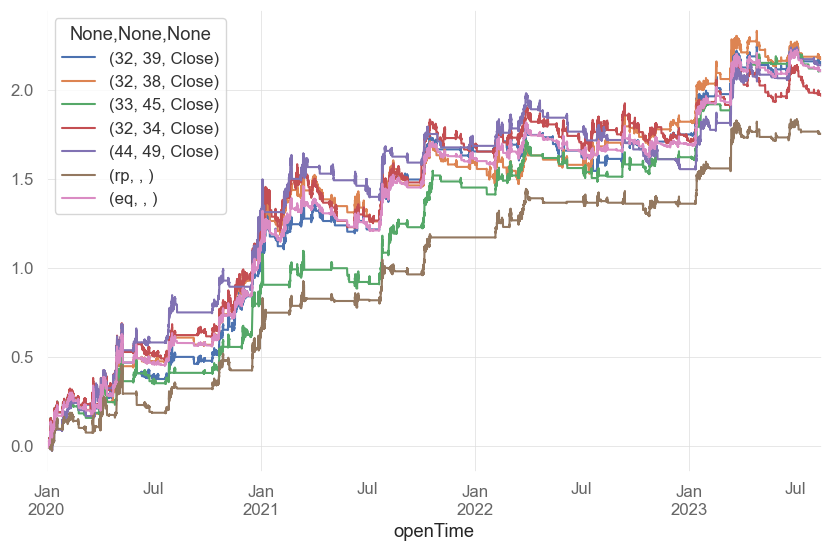

In [10]:
entries_list = []
exits_list = []

for param in idx_best_5_sharpe:

    signal = MyInd.run(price_all['Close'] , rsi_window=param[0], filter_window=param[1], param_product = True)

    entries = signal.signals == 1
    exits = signal.signals == -1
    entries_list.append(entries)
    exits_list.append(exits)

entries_df = pd.concat(entries_list, axis = 1)
exits_df = pd.concat(exits_list, axis = 1)

portfolio = vbt.Portfolio.from_signals(
    price_all['Close'].shift(-1),
    entries_df,
    exits_df,
    freq = '15m', 
    direction = 'longonly',
    sl_stop = 0.03,
    fees = 0.0015,
    init_cash=10000
)

rett = portfolio.returns()

n = 72 * 6
rolling_risk = rett.rolling(n).std()
w_df_ = ((1/rolling_risk).T/(1/rolling_risk).sum(axis = 1)).T

rett['rp'] = (rett * w_df_).sum(axis = 1)
rett['eq'] = rett.iloc[:, :5].mean(axis = 1) 

rett.cumsum().plot()

df_metrics = pd.DataFrame()
for col in rett.columns:
    df_metrics[col] = qs.reports.metrics(rett[col], mode='full', display=False, periods_per_year = 4 * 24 * 365)

df_metrics.head(50)

<Axes: title={'center': 'Cumsum'}, xlabel='openTime'>

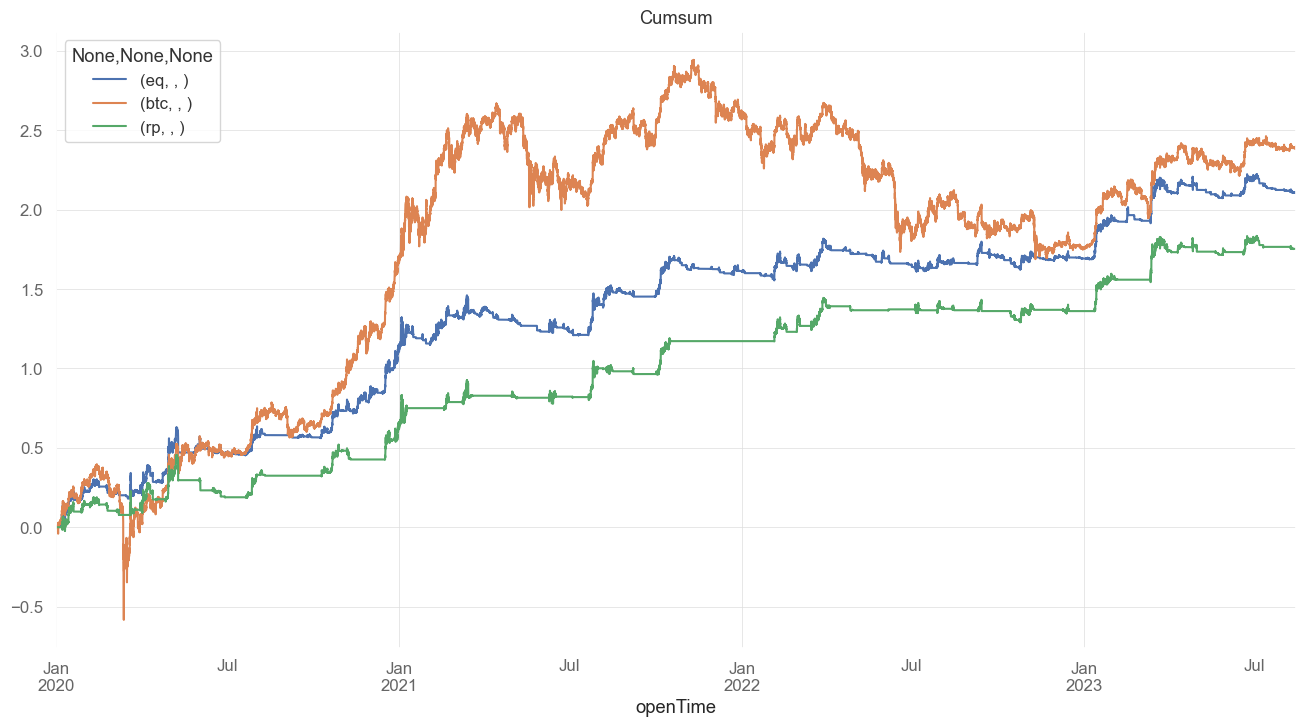

In [11]:
rett['btc'] = df['Close'].pct_change()
fig, ax = plt.subplots(figsize=(16,8))
rett[['eq', 'btc', 'rp']].cumsum().plot(ax=ax, title = 'Cumsum')

In [12]:
qs_metrics = pd.DataFrame()

days = 365
compounded = True

qs_metrics["benchmark"] = qs.reports.metrics(rett['btc'], mode='full', display=False, periods_per_year =4 * 24 * days, compounded = compounded)
qs_metrics["eq_in_sample"] = qs.reports.metrics(rett['eq']['2020-01-01':'2022-08-31'], mode='full', display=False, periods_per_year =4 * 24 * days, compounded = compounded)
qs_metrics["eq_out_sample"] = qs.reports.metrics(rett['eq']['2022-09-01':'2023-08-15'], mode='full', display=False, periods_per_year =4 * 24 * days, compounded = compounded)
qs_metrics["eq_all"] = qs.reports.metrics(rett['eq'], mode='full', display=False, periods_per_year =4 * 24 * days, compounded = compounded)
qs_metrics["rp_in_sample"] = qs.reports.metrics(rett['rp']['2020-01-01':'2022-08-31'], mode='full', display=False, periods_per_year =4 * 24 * days, compounded = compounded)
qs_metrics["rp_out_sample"] = qs.reports.metrics(rett['rp']['2022-09-01':'2023-08-15'], mode='full', display=False, periods_per_year =4 * 24 * days, compounded = compounded)
qs_metrics["rp_all"] = qs.reports.metrics(rett['rp'], mode='full', display=False, periods_per_year =4 * 24 * days, compounded = compounded)

In [13]:
day_rett = rett.resample("1D").sum()
print(day_rett)
mean = np.mean(day_rett['eq'])*252
print(mean)
std = np.std(day_rett['eq']) * (252**0.5)
sharpe = round(mean/std, 4)
print(sharpe)

                  32                  33        32    44        rp        eq  \
                  39        38        45        34    49                       
               Close     Close     Close     Close Close                       
openTime                                                                       
2020-01-01  0.000000  0.000000  0.000000  0.000000   0.0  0.000000  0.000000   
2020-01-02  0.000000  0.000000  0.000000  0.000000   0.0  0.000000  0.000000   
2020-01-03  0.015027  0.015027  0.015027  0.015027   0.0  0.000000  0.012022   
2020-01-04  0.006498  0.006498  0.006498  0.006498   0.0  0.000000  0.005198   
2020-01-05 -0.000351 -0.000351 -0.000351 -0.000351   0.0  0.000000 -0.000281   
...              ...       ...       ...       ...   ...       ...       ...   
2023-08-11 -0.001718 -0.001718  0.000000 -0.001718   0.0 -0.000738 -0.001031   
2023-08-12  0.000757  0.000757  0.000000  0.000757   0.0 -0.000117  0.000454   
2023-08-13 -0.003412 -0.003412  0.000000

In [14]:
qs_metrics.head(60)

,benchmark,eq_in_sample,eq_out_sample,eq_all,rp_in_sample,rp_out_sample,rp_all
Start Period,2020-01-01,2020-01-01,2022-09-01,2020-01-01,2020-01-01,2022-09-01,2020-01-01
End Period,2023-08-15,2022-08-31,2023-08-15,2023-08-15,2022-08-31,2023-08-15,2023-08-15
Risk-Free Rate,0,0,0,0,0,0,0
Time in Market,1.0,0.49,0.53,0.5,0.26,0.32,0.28
Cumulative Return,3.1,3.45,0.51,5.71,2.47,0.43,3.95
CAGR﹪,0.31,0.47,0.35,0.44,0.38,0.29,0.36
Sharpe,0.9,1.77,1.7,1.74,1.7,1.58,1.67
Prob. Sharpe Ratio,0.96,1.0,0.95,1.0,1.0,0.94,1.0
Smart Sharpe,0.89,1.77,1.61,1.73,1.69,1.5,1.64
Sortino,1.28,2.48,2.48,2.46,2.38,2.28,2.35


                           Benchmark    Strategy
-------------------------  -----------  -----------
Start Period               2020-01-03   2020-01-03
End Period                 2023-08-15   2023-08-15
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       50.0%

Total Return               241.44%      210.49%
CAGR﹪                     26.44%       24.17%

Sharpe                     0.91         1.75
Prob. Sharpe Ratio         95.79%       99.95%
Smart Sharpe               0.9          1.73
Sortino                    1.29         2.46
Smart Sortino              1.28         2.44
Sortino/√2                 0.91         1.74
Smart Sortino/√2           0.9          1.73
Omega                      1.05         1.05

Max Drawdown               -77.27%      -23.0%
Longest DD Days            643          292
Volatility (ann.)          73.71%       33.34%
R^2                        0.0          0.0
Information Ratio          -0.0         -0.0
Calmar              

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2021-03-13,2021-07-10,2021-08-08,148,-23.002339,-22.871998
2,2022-03-28,2022-07-06,2023-01-13,292,-18.947326,-18.558040
3,2020-05-08,2020-07-20,2020-10-21,167,-16.904152,-16.618903
4,2021-01-03,2021-02-02,2021-02-19,48,-16.684764,-16.020205
5,2021-10-20,2022-02-04,2022-02-08,111,-14.503154,-13.744971


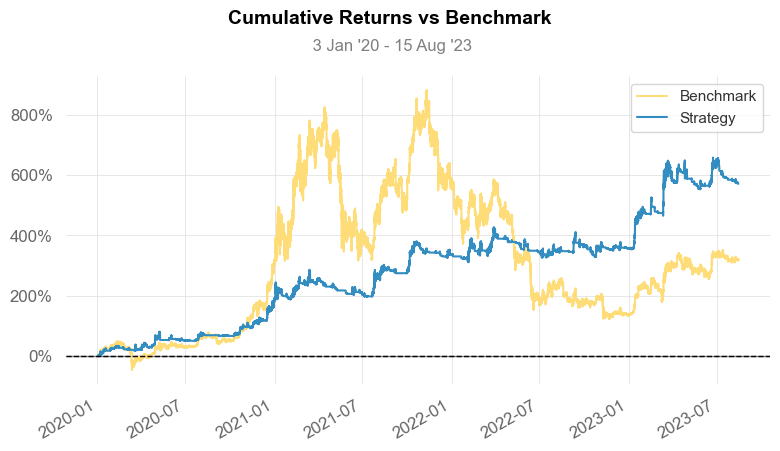

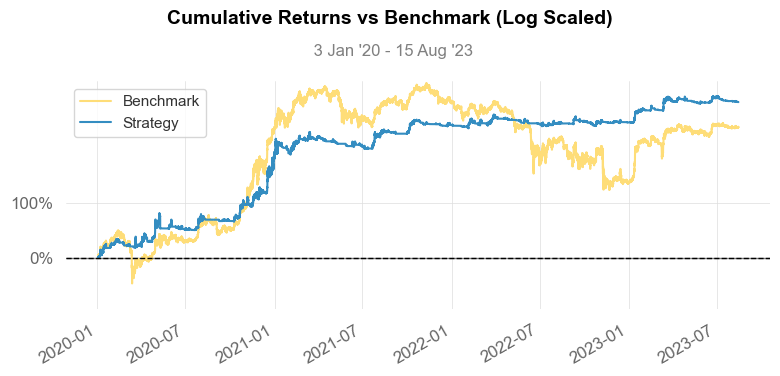

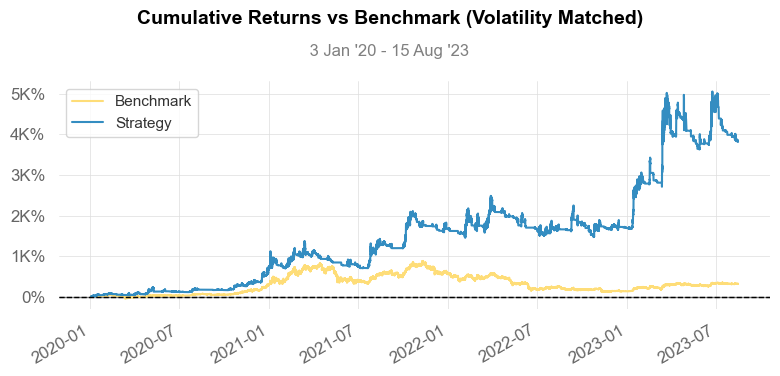

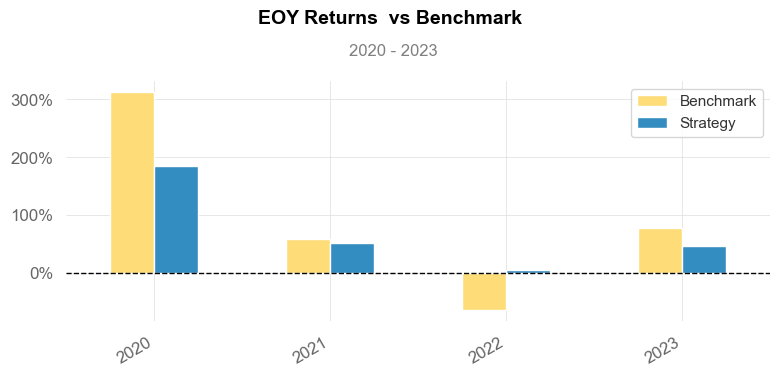

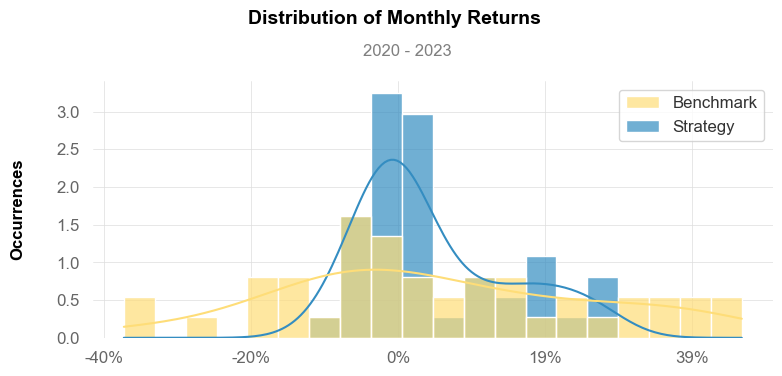

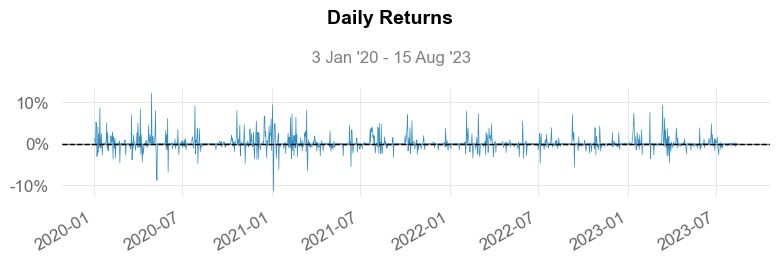

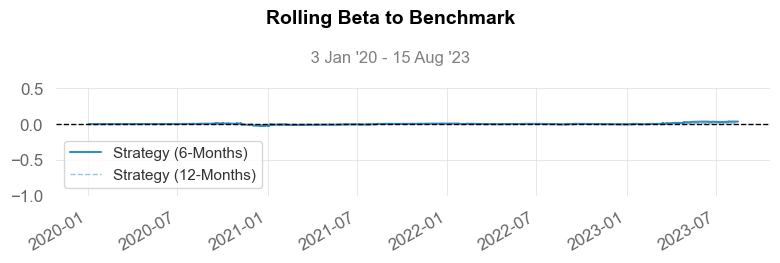

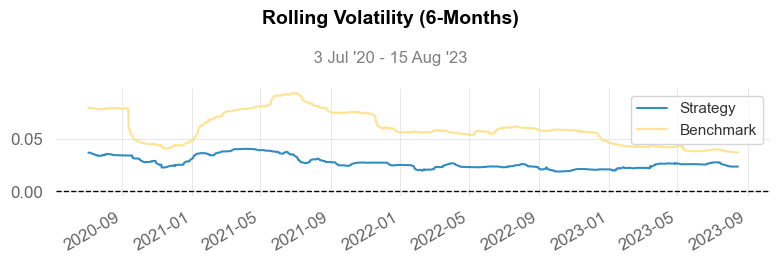

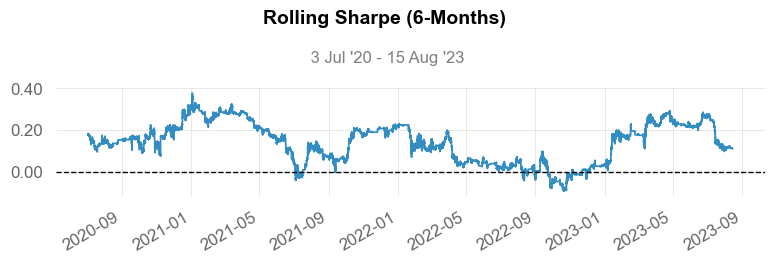

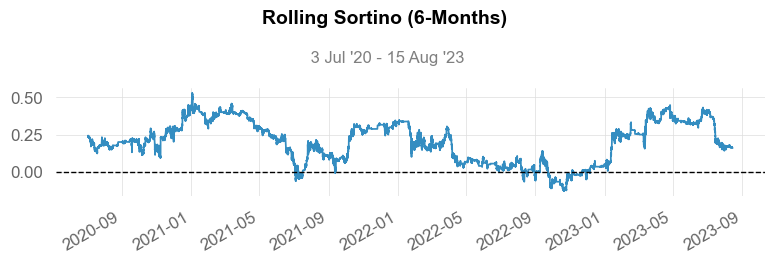

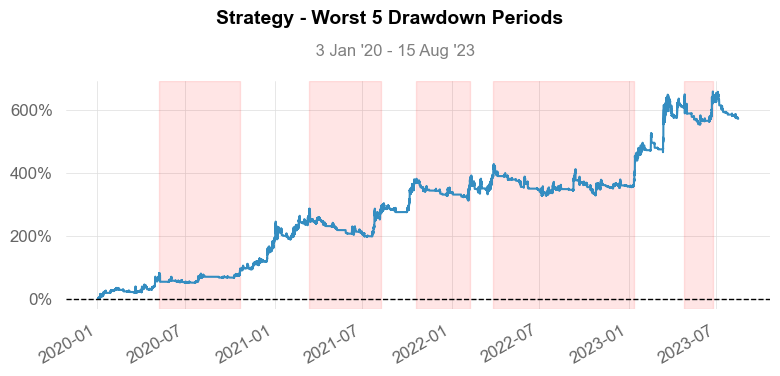

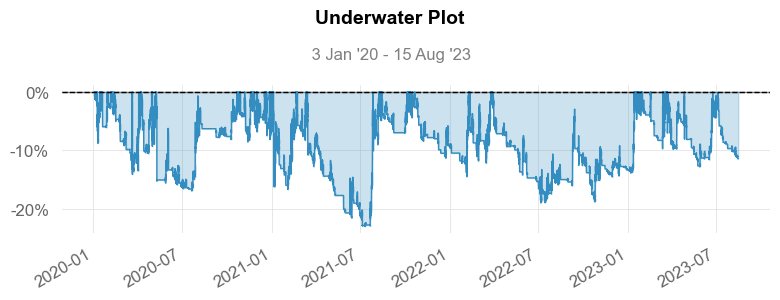

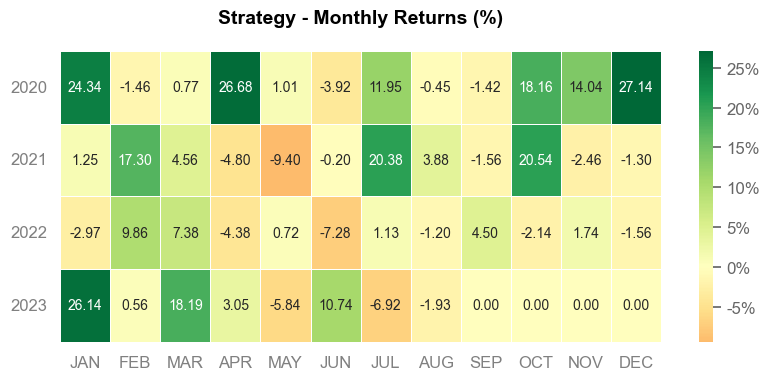

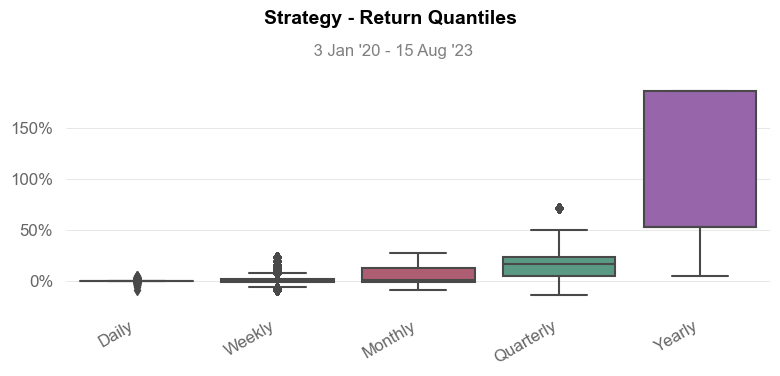

In [15]:
qs.reports.full(rett['eq'], benchmark = rett['btc'], periods_per_year= 24 * 4 *365, compounded=False, active_returns=False)